# Prediction

- **Predicting**: PC1 Neural data
- **Predictor**: Features for gabor filter banks of various sizes (reduced to various numbers of PCs)
- **Plotting**: Gabor filter bank mean FEV vs. number of feats PCs used (line)
- **Plotting**: Gabor filter bank mean FEV for each gabor, with best performing number of PCs (bar)

In [1]:
from cortexlib.utils.file import write_json_file, save_filtered_neural_data, save_model_features, Model
from cortexlib.mouse import CortexlabMouse
from cortexlib.images import CortexlabImages
from cortexlib.gabor import GaborFeatureExtractor
from cortexlib.predictor import NeuralResponsePredictor
from cortexlib.utils.plotting import gabor_filter_colours
from cortexlib.utils.random import set_global_seed
from cortexlib.utils.logging import Logger
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import pandas as pd

logger = Logger()
set_global_seed()

IMAGE_SIZE=(96, 96)

In [2]:
mouse = CortexlabMouse()

logger.progress("Computing null distributions for all neurons")
null_srv_all_neurons = mouse.compute_null_all_neurons(n_shuffles=100)
logger.success(f"Null distributions computed")

real_srv_all_neurons = mouse.compute_real_srv_all_neurons()
reliable_neuron_indices = mouse.get_reliable_neuron_indices(
            null_srv_all_neurons, real_srv_all_neurons, percentile_threshold=99)
neural_responses_mean, neural_responses, _ = mouse.get_responses_for_reliable_neurons(reliable_neuron_indices, real_srv_all_neurons, num_neurons=500)

logger.info(f"Neural responses shape: {neural_responses.shape}")

14:41:16 | INFO     | ⏳ Computing null distributions for all neurons...
14:41:39 | SUCCESS  | ✅ Null distributions computed!
14:41:40 | INFO     | ℹ️ Neural responses shape: (1573, 2, 500)


In [3]:
save_filtered_neural_data(
    mouse_id='1', # TODO: use real mouse.id
    neural_responses=neural_responses,
    neural_responses_mean=neural_responses_mean)

14:41:40 | INFO     | ℹ️ Skipping save, file already exists at /Users/callummessiter/workspace/msc-neuro/research-project/analysis/mouse_1/_neural_data/neural_data_mouse_1.pt


In [4]:
# Gabor filters are grayscale so require only one channel
images = CortexlabImages(size=IMAGE_SIZE, channels=1)

logger.progress("Loading and preprocessing images shown to mouse")
image_dataset = images.load_images_shown_to_mouse(mouse.image_ids)
logger.success("Images processed")

dataloader = DataLoader(image_dataset, batch_size=len(image_dataset))
images_tensor, labels = next(iter(dataloader))

14:41:40 | INFO     | ⏳ Loading and preprocessing images shown to mouse...
14:41:54 | SUCCESS  | ✅ Images processed!


In [5]:
gabor_feature_extractor = GaborFeatureExtractor()

logger.progress("Extracting Gabor features from images")
gabor_features = gabor_feature_extractor.extract_features(images_tensor)
logger.success("Gabor features extracted")

14:41:54 | INFO     | ⏳ Extracting Gabor features from images...
14:42:15 | SUCCESS  | ✅ Gabor features extracted!


In [6]:
save_model_features(model=Model.GABOR, mouse_id="1", features=gabor_features, labels=labels) # TODO: use real mouse.id

14:42:16 | INFO     | ℹ️ Skipping save, file already exists at /Users/callummessiter/workspace/msc-neuro/research-project/analysis/mouse_1/_model_features/gabor_features_mouse_1.pt


In [7]:
fev_results = []

logger.progress("Running regressions: Gabor Feats => PC1 Neural Data")
for filter, feats in gabor_features.items():
    logger.progress(f"Gabor {filter}")

    for n_pcs in [None, 1, 2, 5, 10, 16]:
        predictor = NeuralResponsePredictor(reduce_image_representation_to_n_pcs=n_pcs, neural_data_pc_index=0)
        fev = predictor.compute_fev(feats, neural_responses)

        fev_results.append({
            'filter': filter,
            'n_pcs': n_pcs,
            'test_r2': fev['test_r2'],
            'mean_fev': fev['mean_fev']
        })

logger.success(f"Regressions complete")

14:42:16 | INFO     | ⏳ Running regressions: Gabor Feats => PC1 Neural Data...
14:42:16 | INFO     | ⏳ Gabor gabor_small...
14:42:17 | INFO     | ⏳ Gabor gabor_medium...
14:42:18 | INFO     | ⏳ Gabor gabor_large...
14:42:19 | SUCCESS  | ✅ Regressions complete!


In [9]:
write_json_file(fev_results, f'./prediction.json')

In [10]:
fev_results_df = pd.DataFrame(fev_results)
fev_results_df.head(12)

,filter,n_pcs,test_r2,mean_fev
0,gabor_small,NaN,0.002423,0.005879
1,gabor_small,1.0,0.001870,0.005299
2,gabor_small,2.0,0.003115,0.006604
3,gabor_small,5.0,0.002378,0.005832
4,gabor_small,10.0,0.002423,0.005879
5,gabor_small,16.0,0.002423,0.005879
6,gabor_medium,NaN,-0.003925,0.000000
7,gabor_medium,1.0,0.001566,0.004980
8,gabor_medium,2.0,0.004206,0.007748
9,gabor_medium,5.0,-0.004586,0.000000


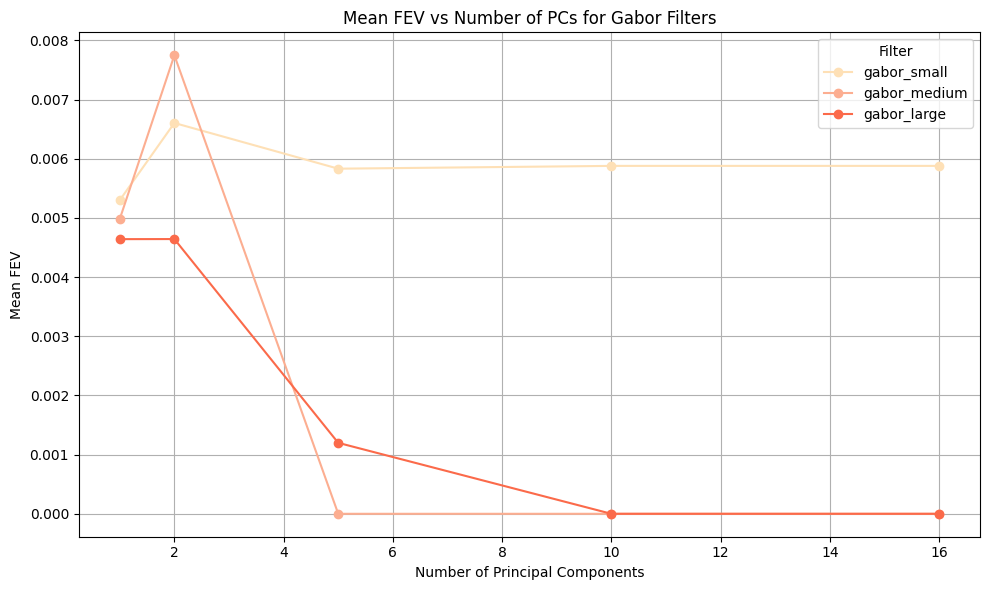

In [11]:
plt.figure(figsize=(10, 6))

for filter in fev_results_df['filter'].unique():
    filter_results = fev_results_df[fev_results_df['filter'] == filter]
    plt.plot(filter_results['n_pcs'], filter_results['mean_fev'], marker='o', color=gabor_filter_colours[filter], label=filter)

plt.xlabel('Number of Principal Components')
plt.ylabel('Mean FEV')
plt.title('Mean FEV vs Number of PCs for Gabor Filters')
plt.legend(title='Filter')
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
best_fev_per_gabor = fev_results_df.loc[fev_results_df.groupby("filter")["mean_fev"].idxmax()]
best_fev_per_gabor

,filter,n_pcs,test_r2,mean_fev
14,gabor_large,2.0,0.001244,0.004643
8,gabor_medium,2.0,0.004206,0.007748
2,gabor_small,2.0,0.003115,0.006604


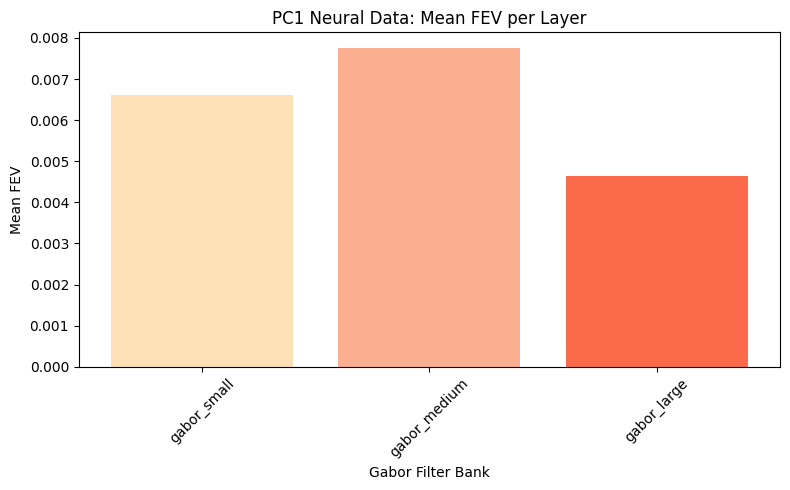

In [18]:
desired_order = ["gabor_small", "gabor_medium", "gabor_large"]
best_fev_per_gabor = best_fev_per_gabor.set_index("filter").loc[desired_order].reset_index()
gabors = [row["filter"] for _, row in best_fev_per_gabor.iterrows()]
mean_fevs = [row["mean_fev"] for _, row in best_fev_per_gabor.iterrows()]

colors = [gabor_filter_colours[gabor] for gabor in gabors]

plt.figure(figsize=(8, 5))
plt.bar(gabors, mean_fevs, color=colors)
plt.ylabel("Mean FEV")
plt.xlabel("Gabor Filter Bank")
plt.title("PC1 Neural Data: Mean FEV per Layer")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()